# Import Module and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
event_data = pd.read_csv('data/all_user_event_data.csv')
profile_data = pd.read_csv('data/all_user_profile_data.csv')
repo_data = pd.read_csv('data/all_user_repo_data.csv')
starred_data = pd.read_csv('data/all_user_starred_data.csv')

In [3]:
event_data = event_data[event_data['event_type'] != 'event_type']

In [4]:
all_users = set(repo_data['user_alias'].unique())

In [5]:
users_with_python = set(repo_data[repo_data['language'] == 'Python']['user_alias'].unique())

In [6]:
users_without_python = list(all_users - users_with_python)

In [7]:
len(all_users), len(users_without_python)

(8465, 2945)

In [8]:
event_data = event_data[~event_data['user_alias'].isin(users_without_python)]
profile_data = profile_data[~profile_data['user_alias'].isin(users_without_python)]
repo_data = repo_data[~repo_data['user_alias'].isin(users_without_python)]
starred_data = starred_data[~starred_data['user_alias'].isin(users_without_python)]

In [9]:
profile_data['followers'].fillna(0, inplace=True)
profile_data['following'].fillna(0, inplace=True)
profile_data['public_repos'].fillna(0, inplace=True)
profile_data['public_gists'].fillna(0, inplace=True)
profile_data['hireable'].fillna(False, inplace=True)

In [10]:
repo_data['stargazers_count'].fillna(0, inplace=True)
repo_data['forks'].fillna(0, inplace=True)
repo_data['fork'].fillna('False', inplace=True)

In [11]:
starred_data['stargazers_count'].fillna(0, inplace=True)

# Define Function

In [12]:
def regression_analysis(X, y):
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    return results

In [13]:
def select_numeric_column(df):
    return df.select_dtypes(include=[np.number])

In [14]:
def plot_corr(df, title):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()
    return corr

In [15]:
def plot_percent_freq(df, field, title, xlim):
    order = df[field].value_counts().index
    total = len(df)
    sns.barplot(y=df[field].value_counts().index, x=df[field].value_counts().values/total, order=order)
    plt.title(title)
    plt.xlim(0, xlim)
    plt.show()

In [16]:
def plot_top10_language_percentage(df, title, xlim):
    language_counts = df.groupby(['user_alias', 'language']).size().unstack(fill_value=0)
    total_repos = df.groupby('user_alias').size()
    language_percentages = (language_counts.T / total_repos).T * 100
    overall_language_percentages = language_percentages.mean()
    top_10_languages = overall_language_percentages.nlargest(10).index
    top_10_language_percentages = language_percentages[top_10_languages]
    melted = top_10_language_percentages.reset_index().melt(id_vars='user_alias', var_name='language', value_name='percentage')
    average_percentages = melted.groupby('language')['percentage'].mean()
    top_10_languages = average_percentages.sort_values(ascending=False).head(10).index
    top_10_melted = melted[melted['language'].isin(top_10_languages)]
    sns.barplot(data=top_10_melted, y='language', x='percentage', order=top_10_languages, errorbar=None)
    plt.title(title)
    plt.xlim(0, xlim)
    plt.show()

In [17]:
def plot_scatter(df, field_x, field_y, field_type, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=field_x, y=field_y, hue=field_type, data=df)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

# Data Analysis

<b>Objective</b>: Get insights into the GitHub activity patterns of GitHub users with a high follower count.

The following steps will be undertaken to analyze the relationships:

<ul>
    <li>1. Determine if there are any disparities in the data fields between users with a high number of followers and those with fewer followers.</li>
    <li>2. If differences are found, conduct a detailed analysis to understand how these fields affect the number of followers and the nature of their influence.</li>
    <li>3. Visualize the data and perform statistical tests with a focus on significant values to better understand the patterns and trends.</li>
    <li>4. Repeat steps 1-3 for each data field.</li>
    <li>5. Compile and summarize the findings from each iteration.</li>
</ul>

## Selecting High-Follower User

In [18]:
 np.exp(4)

54.598150033144236

In [19]:
threshold = np.exp(4) # Reasons for choosing this threshold can be found in EDA notebook
high_follower_users = profile_data[profile_data['followers'] > threshold]

In [20]:
high_follower_users.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
10,usr10,User,True,Ho Chi Minh City/Viet Nam,126.0,170.0,50.0,17.0,2015-05-07T09:55:21Z,2023-12-14T15:56:05Z
29,usr29,User,False,The Netherlands/Rotterdam,84.0,85.0,37.0,4.0,2011-03-18T17:11:58Z,2024-01-08T20:02:08Z
61,usr61,User,False,Belo Horizonte - MG/Brazil,226.0,102.0,50.0,0.0,2014-12-15T20:36:44Z,2023-12-14T12:24:33Z
82,usr82,User,True,Utah,128.0,6.0,110.0,59.0,2009-02-05T20:46:03Z,2024-01-09T16:56:59Z
88,usr88,User,False,Eindhoven/the Netherlands,70.0,0.0,10.0,0.0,2014-02-25T18:53:32Z,2024-01-12T10:08:54Z


In [21]:
len(high_follower_users)

259

In [22]:
high_follower_aliases = high_follower_users['user_alias']

In [23]:
high_follower_aliases.head()

10    usr10
29    usr29
61    usr61
82    usr82
88    usr88
Name: user_alias, dtype: object

In [24]:
high_follower_event_data = event_data[event_data['user_alias'].isin(high_follower_aliases)]
high_follower_repo_data = repo_data[repo_data['user_alias'].isin(high_follower_aliases)]
high_follower_starred_data = starred_data[starred_data['user_alias'].isin(high_follower_aliases)]

In [25]:
low_follower_users = profile_data[~profile_data['user_alias'].isin(high_follower_aliases)]
low_follower_event_data = event_data[~event_data['user_alias'].isin(high_follower_aliases)]
low_follower_repo_data = repo_data[~repo_data['user_alias'].isin(high_follower_aliases)]
low_follower_starred_data = starred_data[~starred_data['user_alias'].isin(high_follower_aliases)]

## Analyze The Relationship

### Profile Data

#### Correlation Analysis

In [26]:
profile_data.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
3,usr3,User,True,Karachi,0.0,0.0,5.0,0.0,2021-09-24T09:04:40Z,2023-05-02T19:11:00Z
5,usr5,User,True,Remote,0.0,6.0,22.0,7.0,2022-06-02T04:04:01Z,2023-12-21T10:06:23Z
6,usr6,User,True,NaN,1.0,2.0,19.0,0.0,2021-08-20T19:03:28Z,2023-12-18T08:21:10Z
7,usr7,User,True,Iran,3.0,7.0,16.0,0.0,2021-06-03T12:52:25Z,2023-10-13T17:19:17Z
9,usr9,User,False,Kiev/Lviv,0.0,0.0,16.0,0.0,2019-04-03T19:46:09Z,2023-03-13T20:20:03Z


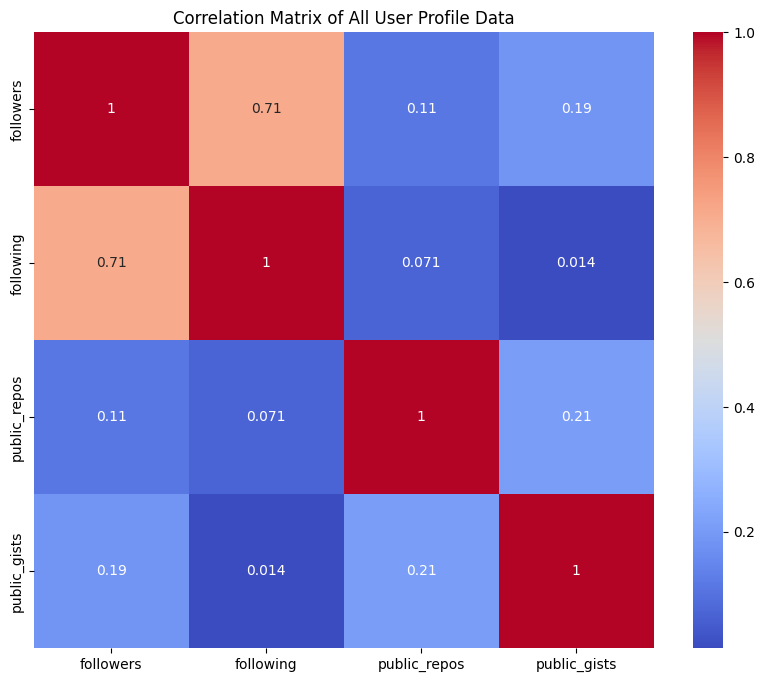

In [27]:
corr = plot_corr(select_numeric_column(profile_data), title='Correlation Matrix of All User Profile Data')

In [28]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.710451,0.110147,0.186690
following,0.710451,1.000000,0.071278,0.013650
public_repos,0.110147,0.071278,1.000000,0.209447
public_gists,0.186690,0.013650,0.209447,1.000000


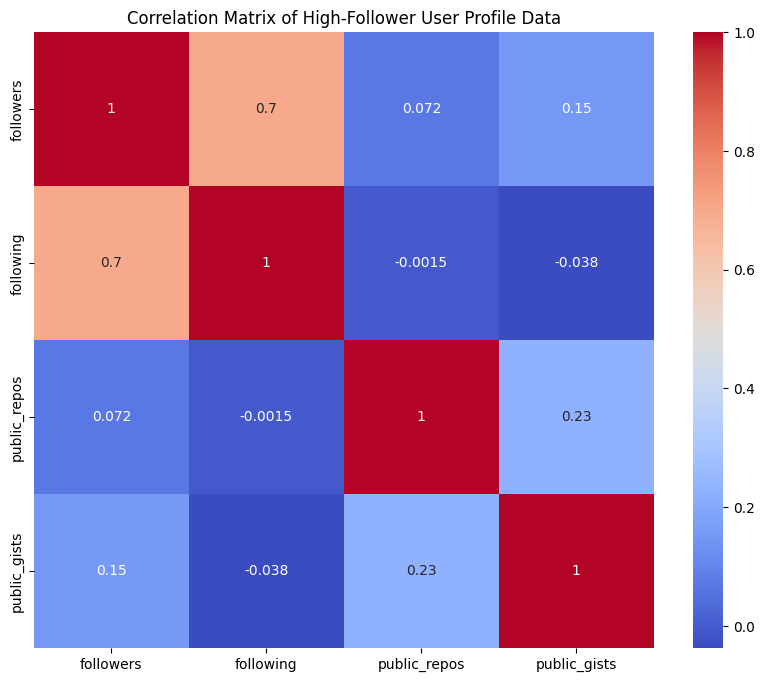

In [29]:
corr = plot_corr(select_numeric_column(high_follower_users), title='Correlation Matrix of High-Follower User Profile Data')

In [30]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.698461,0.071767,0.153639
following,0.698461,1.000000,-0.001542,-0.037597
public_repos,0.071767,-0.001542,1.000000,0.227759
public_gists,0.153639,-0.037597,0.227759,1.000000


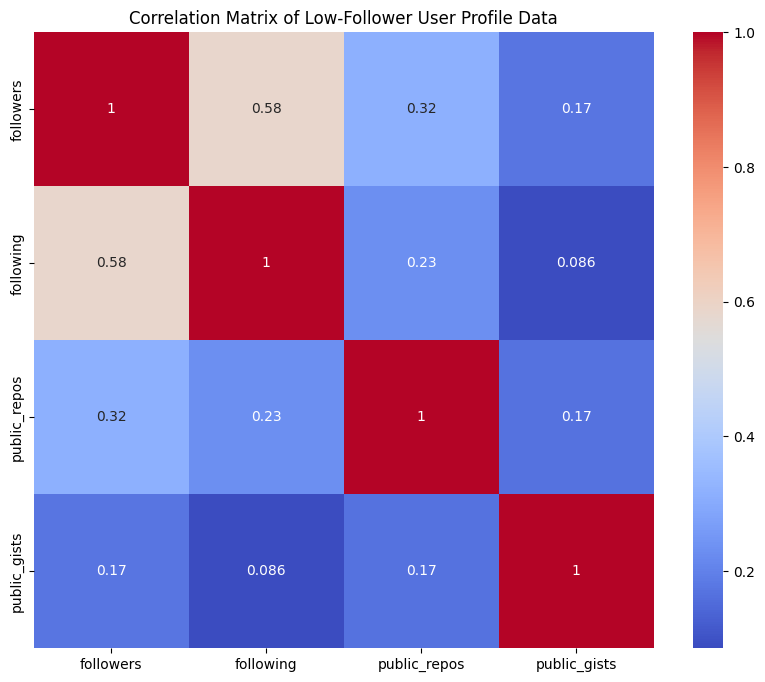

In [31]:
corr = plot_corr(select_numeric_column(low_follower_users), title='Correlation Matrix of Low-Follower User Profile Data')

In [32]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.584218,0.317116,0.174360
following,0.584218,1.000000,0.231154,0.085552
public_repos,0.317116,0.231154,1.000000,0.165063
public_gists,0.174360,0.085552,0.165063,1.000000


By analyzing the Correlation Matrix of each field in the profile data of all users and specifically high-follower users and observing a significant correlation between the `following` and `followers` fields. A correlation coefficient of 0.710451 and 0.698461 indicates a strong positive relationship, suggesting that as the number of users one follows increases, so does the number of followers they have.

#### Regression Analysis of `following` and `followers`

In [33]:
profile_data = profile_data.dropna(subset=['following', 'followers'])

In [34]:
results = regression_analysis(X = profile_data['following'], y = profile_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5744.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        23:26:26   Log-Likelihood:                -37528.
No. Observations:                5638   AIC:                         7.506e+04
Df Residuals:                    5636   BIC:                         7.507e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7144      2.514      2.273      0.023       0.785      10.644
following      0.8305      0.011     75.789      0.000       0.809       0.852
==============================================================================
Omnibus:                    14025.241   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        284535500.783
Skew:                          26.554   Prob(JB):                         0.00
Kurtosis:                    1102.272   Cond. No.                         230.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
results.pvalues['following']

0.0

R-squared = 0.505, This is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variable. Meaning that approximately 49.3% of the variability in `followers` can be explained by `following`.

F-statistic = 5744, This is a measure of how significant the fit of the model is.

Prob (F-statistic) = 0.00 (The associated p-value) is less than 0.05 means that the independent variable, `following`, is a statistically significant predictor of `followers`.

coef for `following` = 0.8305, This is the change in the `followers` variable for a one-unit change in the `following` variable, holding all other variables constant. In this case, for each additional user that someone follows, their followers will increase by about 0.83.

### Event Data

#### Plot Percentage Of Event Frequency

In [36]:
event_data.head()

,user_alias,event_type,created_at
41,usr5,WatchEvent,2024-01-11T13:04:19Z
42,usr5,PushEvent,2024-01-06T03:48:18Z
43,usr5,PushEvent,2024-01-02T16:43:32Z
44,usr5,CreateEvent,2023-12-28T09:35:34Z
45,usr5,CreateEvent,2023-12-28T05:03:51Z


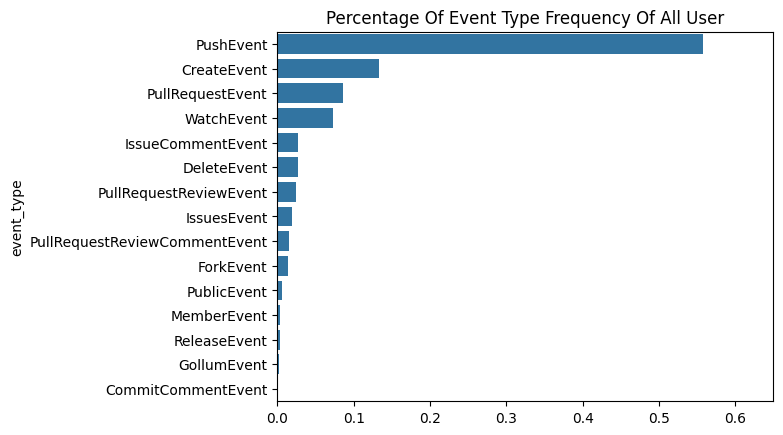

In [37]:
plot_percent_freq(event_data, 'event_type', title='Percentage Of Event Type Frequency Of All User', xlim=0.65)

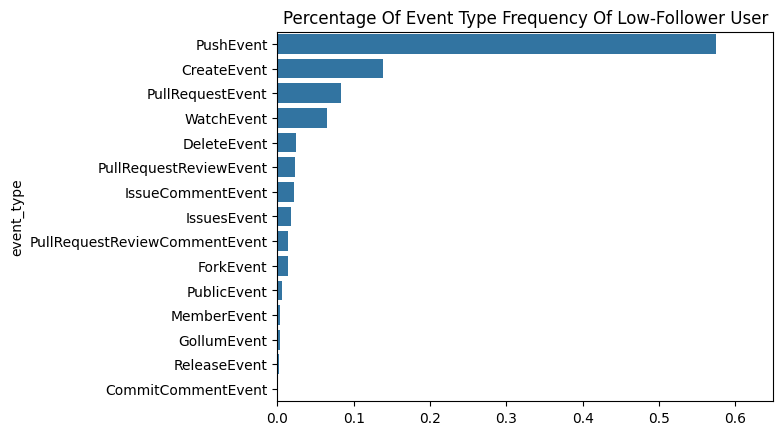

In [38]:
plot_percent_freq(low_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of Low-Follower User', xlim=0.65)

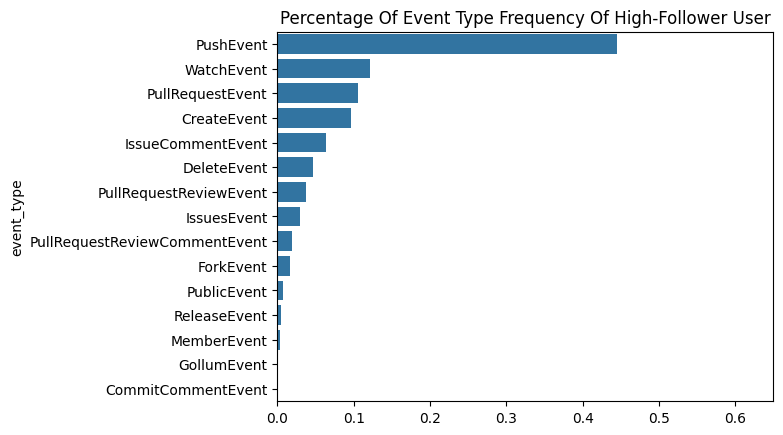

In [39]:
plot_percent_freq(high_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of High-Follower User', xlim=0.65)

These BarChart revealed a notable difference in the frequency of three specific event types: `PushEvent`, `CreateEvent` and `WatchEvent`.

`PushEvent` This could imply that high-follower users tend to push data to their GitHub repositories less frequently than low-follower users.

`CreateEvent` High-follower users have a lower frequency of CreateEvent compared to both low-follower users and the overall user base. This could imply that high-follower may not create new repositories as often as their low-follower counterparts.

`WatchEvent` High-follower users also have a higher frequency of WatchEvent. This indicates that they are more likely to watch or follow other users' repositories. This could be a reflection of their engagement with the GitHub community, keeping track of others' works and possibly gaining inspiration for their own projects.

#### Regression Analysis of `PushEvent`, `CreateEvent` and `WatchEvent` Frequency

In [40]:
event_counts = event_data.groupby(['user_alias', 'event_type']).size().unstack(fill_value=0)
event_counts.reset_index(inplace=True)

merged_data = pd.merge(profile_data[['user_alias', 'followers']], event_counts, on='user_alias')

In [41]:
merged_data.head()

,user_alias,followers,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent
0,usr5,0.0,0,6,0,0,0,0,1,0,0,0,0,0,4,0,1
1,usr6,1.0,0,8,1,0,0,1,1,2,2,1,0,0,220,1,2
2,usr10,126.0,0,0,0,1,0,1,0,0,0,0,0,0,4,0,189
3,usr11,7.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,usr14,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
y = merged_data['followers']

##### `PushEvent`

In [43]:
results = regression_analysis(X = merged_data['PushEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     20.85
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           5.17e-06
Time:                        23:26:27   Log-Likelihood:                -19876.
No. Observations:                2932   AIC:                         3.976e+04
Df Residuals:                    2930   BIC:                         3.977e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8609      4.562      3.477      0.001       6.915      24.806
PushEvent      0.4132      0.091      4.566      0.000       0.236       0.591
==============================================================================
Omnibus:                     7618.883   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        123227442.919
Skew:                          29.436   Prob(JB):                         0.00
Kurtosis:                    1005.605   Cond. No.                         58.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
results.pvalues['PushEvent']

5.1748034845435516e-06

The p-value for `PushEvent` is 5.17e-06, which is less than 0.05. Therefore, the assumption that the amount of `PushEvent` have an effects on users' follower count is statistically supported.

for each additional `PushEvent` that someone makes, their followers will increase by about 0.41.

##### `CreateEvent`

In [45]:
results = regression_analysis(X = merged_data['CreateEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     21.23
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           4.25e-06
Time:                        23:26:27   Log-Likelihood:                -19876.
No. Observations:                2932   AIC:                         3.976e+04
Df Residuals:                    2930   BIC:                         3.977e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.6855      4.685      3.134      0.002       5.499      23.872
CreateEvent     1.9233      0.417      4.607      0.000       1.105       2.742
==============================================================================
Omnibus:                     7647.820   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        127476230.238
Skew:                          29.716   Prob(JB):                         0.00
Kurtosis:                    1022.769   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
results.pvalues['CreateEvent']

4.251771857218208e-06

The p-value for `CreateEvent` is 4.25e-06, which is also less than 0.05. Therefore, the assumption that the amount of `CreateEvent` have an effects on users' follower count is statistically supported.

for each additional `CreateEvent` that someone makes, their followers will increase by about 1.92.

##### `WatchEvent`

In [47]:
results = regression_analysis(X = merged_data['WatchEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.329
Date:                Mon, 08 Apr 2024   Prob (F-statistic):             0.0210
Time:                        23:26:27   Log-Likelihood:                -19884.
No. Observations:                2932   AIC:                         3.977e+04
Df Residuals:                    2930   BIC:                         3.978e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.0694      4.072      5.911      0.000      16.085      32.054
WatchEvent     0.7116      0.308      2.308      0.021       0.107       1.316
==============================================================================
Omnibus:                     7656.104   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        127944218.158
Skew:                          29.800   Prob(JB):                         0.00
Kurtosis:                    1024.636   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
results.pvalues['WatchEvent']

0.02104827778173691

the p-value for `WatchEvent` is 0.0210, which is also less than 0.05. Therefore, the assumption that the amount of `WatchEvent` have an effects on users' follower count is statistically supported.

for each additional `WatchEvent` that someone makes, their followers will increase by about 0.71.

### Repo Data

In [49]:
repo_data.head()

,user_alias,description,fork,stargazers_count,language,topics,forks
105,usr3,ZABx Blockchain is a public/layer 2 and PoS Bl...,False,0.0,JavaScript,blockchain/ethereum,0.0
106,usr3,Hospital Management System in Java,False,0.0,Java,NaN,0.0
107,usr3,This is A Point of Sales Management made by me...,False,0.0,C,NaN,0.0
108,usr3,Book Recommendation System In Python,False,0.0,Python,ai/python,0.0
109,usr3,Bus Ticketing System in Java,False,0.0,Java,NaN,0.0


### Analyzing the correlation between providing repository descriptions and topics, and the follower count for all users.

In [50]:
all_users_percentages = repo_data.groupby('user_alias')[['description', 'topics']].apply(lambda x: x.notna().mean() * 100)

In [51]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], all_users_percentages, on='user_alias')

In [52]:
merged_data['user_type'] = ['high-follower user' if x > threshold else 'low-follower user' for x in merged_data['followers']]

In [53]:
merged_data.head()

,user_alias,followers,description,topics,user_type
0,usr3,0.0,100.000000,40.00,low-follower user
1,usr5,0.0,31.818182,0.00,low-follower user
2,usr6,1.0,52.631579,0.00,low-follower user
3,usr7,3.0,81.250000,6.25,low-follower user
4,usr9,0.0,68.750000,6.25,low-follower user


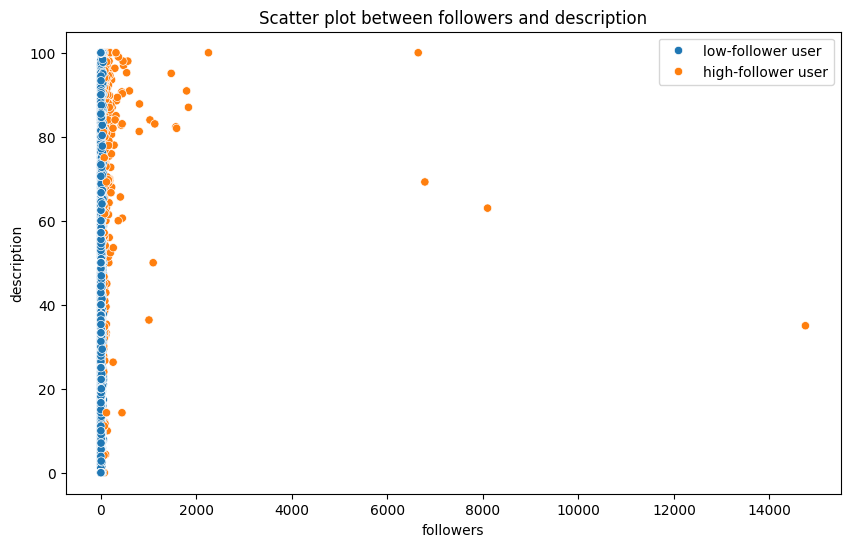

In [54]:
plot_scatter(df = merged_data, field_x = 'followers', field_y = 'description', field_type = 'user_type', title = 'Scatter plot between followers and description')

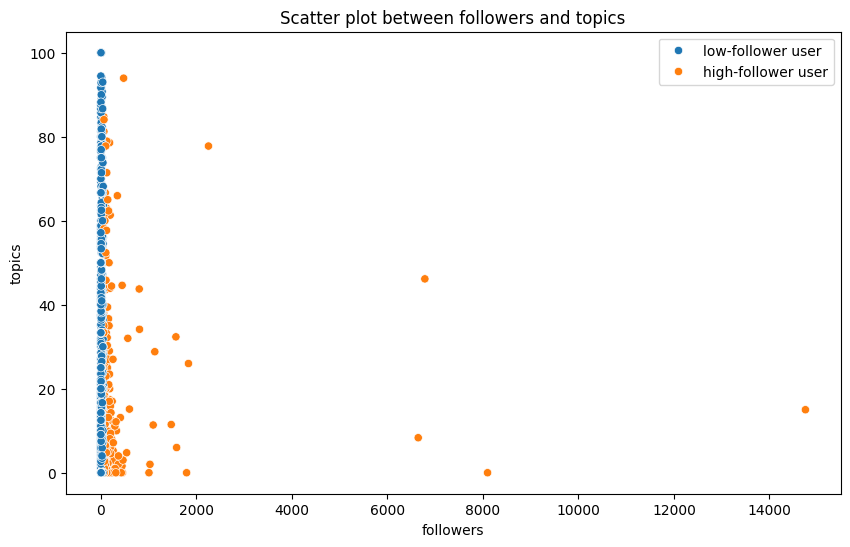

In [55]:
plot_scatter(df = merged_data, field_x = 'followers', field_y = 'topics', field_type = 'user_type', title = 'Scatter plot between followers and topics')

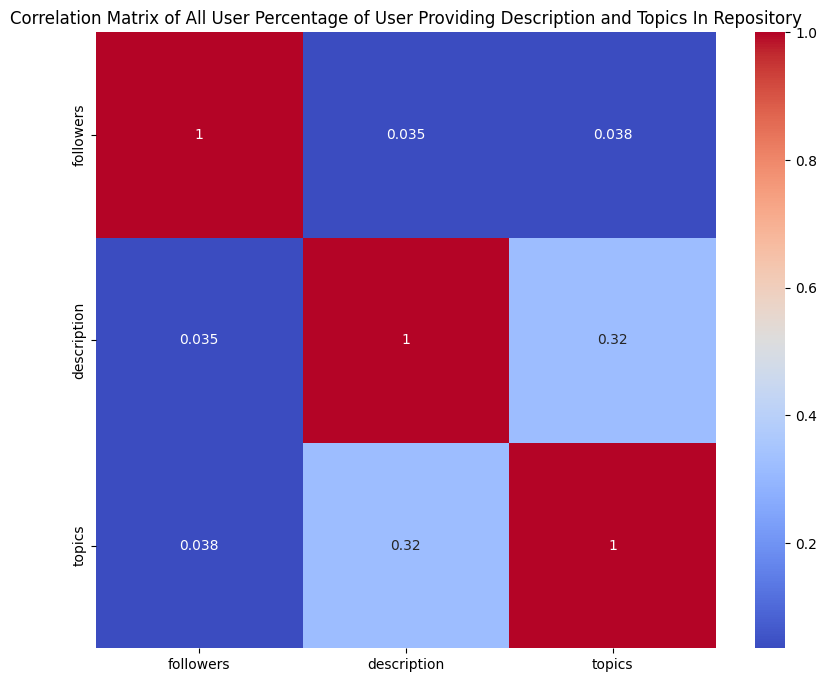

In [56]:
corr = plot_corr(select_numeric_column(merged_data), title='Correlation Matrix of All User Percentage of User Providing Description and Topics In Repository')

In [57]:
corr

,followers,description,topics
followers,1.000000,0.035356,0.037762
description,0.035356,1.000000,0.320054
topics,0.037762,0.320054,1.000000


By analyzing the correlation matrix, which encompasses the percentage of all users providing descriptions and topics, no significant correlation was found.

### Analyzing the correlation between numbers of star and forks, with the follower count for all users.

In [58]:
user_aggregates = repo_data.groupby('user_alias')[['stargazers_count', 'forks']].sum().reset_index()

In [59]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], user_aggregates, on='user_alias')

In [60]:
merged_data['user_type'] = ['high-follower user' if x > threshold else 'low-follower user' for x in merged_data['followers']]

In [61]:
merged_data.head()

,user_alias,followers,stargazers_count,forks,user_type
0,usr3,0.0,0.0,0.0,low-follower user
1,usr5,0.0,0.0,1.0,low-follower user
2,usr6,1.0,1.0,1.0,low-follower user
3,usr7,3.0,4.0,0.0,low-follower user
4,usr9,0.0,3.0,5.0,low-follower user


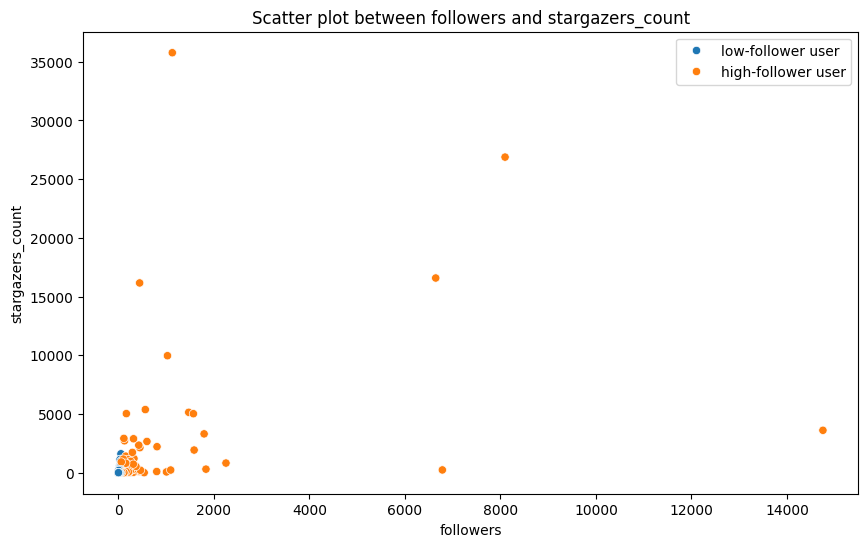

In [62]:
plot_scatter(df = merged_data, field_x = 'followers', field_y = 'stargazers_count', field_type = 'user_type', title = 'Scatter plot between followers and stargazers_count')

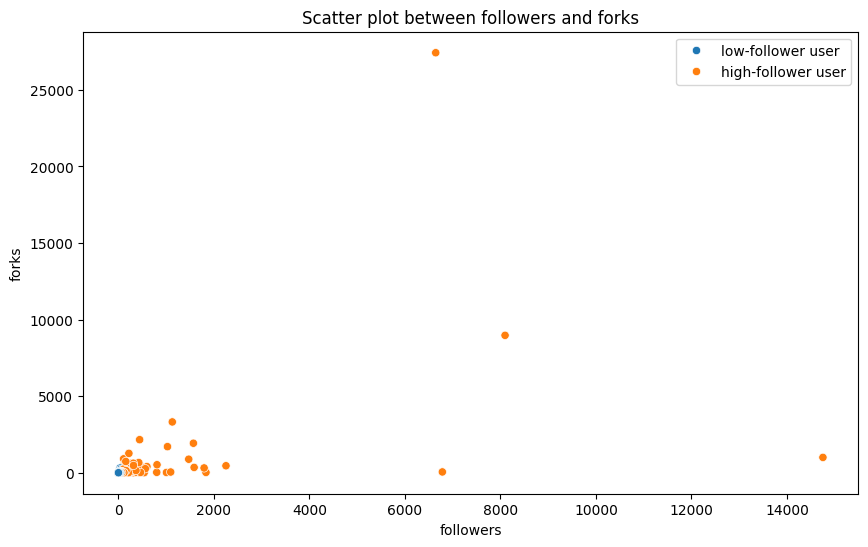

In [63]:
plot_scatter(df = merged_data, field_x = 'followers', field_y = 'forks', field_type = 'user_type', title = 'Scatter plot between followers and forks')

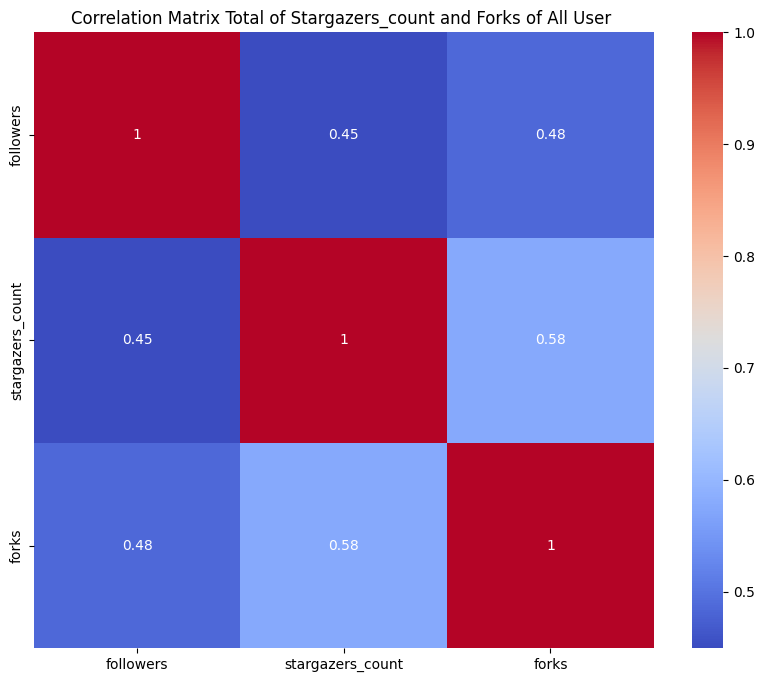

In [64]:
corr = plot_corr(select_numeric_column(merged_data), title='Correlation Matrix Total of Stargazers_count and Forks of All User ')

In [65]:
corr

,followers,stargazers_count,forks
followers,1.000000,0.449443,0.484092
stargazers_count,0.449443,1.000000,0.577845
forks,0.484092,0.577845,1.000000


In [66]:
results = regression_analysis(X = merged_data['stargazers_count'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     1397.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          1.01e-272
Time:                        23:26:34   Log-Likelihood:                -38117.
No. Observations:                5520   AIC:                         7.624e+04
Df Residuals:                    5518   BIC:                         7.625e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.7302      3.256      4.217      0.000       7.347      20.113
stargazers_count     0.1690      0.005     37.373      0.000       0.160       0.178
==============================================================================
Omnibus:                    16124.055   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1206010804.851
Skew:                          40.138   Prob(JB):                         0.00
Kurtosis:                    2291.467   Cond. No.                         721.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
results.pvalues['stargazers_count']

1.0141034939506064e-272

the p-value for `stargazers_count` is 1.01e-272, which is less than 0.05. Therefore, the assumption that the amount of `stargazers_count` have an effects on users' follower count is statistically supported.

for each star in total `stargazers_count` that someone have in all of their repositories, their followers will increase by about 0.17.

In [68]:
results = regression_analysis(X = merged_data['forks'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     1689.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          2.47e-322
Time:                        23:26:34   Log-Likelihood:                -38003.
No. Observations:                5520   AIC:                         7.601e+04
Df Residuals:                    5518   BIC:                         7.602e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5747      3.185      5.204      0.000      10.331      22.818
forks          0.3305      0.008     41.096      0.000       0.315       0.346
==============================================================================
Omnibus:                    17090.893   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1628568643.045
Skew:                          47.240   Prob(JB):                         0.00
Kurtosis:                    2662.287   Cond. No.                         396.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
results.pvalues['forks']

0.0

the p-value for `forks` is 2.47e-322, which is also less than 0.05. Therefore, the assumption that the amount of `forks` have an effects on users' follower count is statistically supported.

for each fork in total `forks` that someone have in all of their repositories, their followers will increase by about 0.33.

### Analyzing the percentage of each language with follower count for high-follower user and low-follower user.

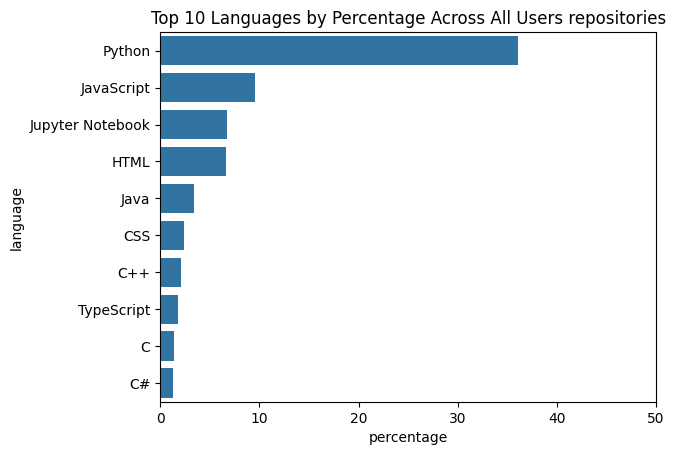

In [70]:
plot_top10_language_percentage(repo_data, title = 'Top 10 Languages by Percentage Across All Users repositories', xlim=50)

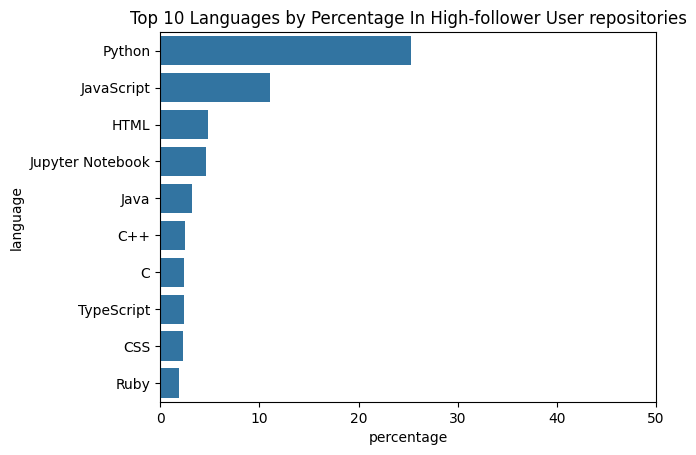

In [71]:
plot_top10_language_percentage(high_follower_repo_data, title = 'Top 10 Languages by Percentage In High-follower User repositories', xlim=50)

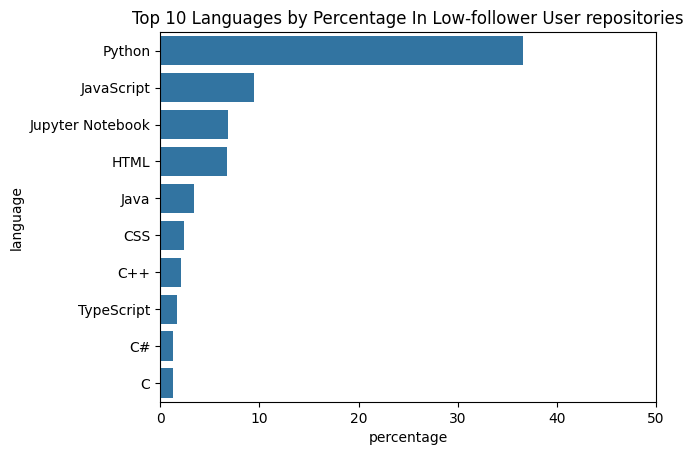

In [72]:
plot_top10_language_percentage(low_follower_repo_data, title = 'Top 10 Languages by Percentage In Low-follower User repositories', xlim=50)

By analyzing the top 10 languages by percentage across all users, high-follower users, and low-follower users, it’s evident that the distribution of language usage is remarkably consistent across all three categories.

In [73]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], repo_data, on='user_alias')

In [74]:
merged_data = merged_data[['user_alias', 'followers', 'language']]

In [75]:
merged_data = merged_data.groupby(['user_alias', 'followers', 'language']).size().unstack(fill_value=0)

In [76]:
total = merged_data.sum(axis=1)
transformed_data = merged_data.div(total, axis=0)
transformed_data.reset_index(inplace=True)

In [77]:
language_to_check = ('Python', 'JavaScript','Jupyter Notebook', 'HTML', 'Java', 'C++', 'C#', 'CSS', 'Ruby', 'TypeScript')

In [78]:
significant_result = []

for language in language_to_check:
    X = transformed_data[language]
    y = transformed_data['followers']
    results = regression_analysis(X, y)
    
    if results.pvalues[language] < 0.05:
        significant_result.append((language, results))

In [79]:
significant_result

[]

### Starred Data

In [80]:
starred_data.head()

,user_alias,full_name,html_url,description,language,topics,stargazers_count
12,usr5,qtchaos/py_mega_account_generator,https://github.com/qtchaos/py_mega_account_gen...,🤖 Create and manage MEGA accounts with ease/up...,Python,generator/mega/mega-nz/mega-nz-account-creator...,44.0
13,usr5,januusio/cryptowallet_risk_scoring,https://github.com/januusio/cryptowallet_risk_...,A free cryptowallet risk scoring tool with ful...,Python,anti-money-laundering/bitcoin/cryptocurrency/c...,213.0
14,usr6,jordan-cutler/path-to-senior-engineer-handbook,https://github.com/jordan-cutler/path-to-senio...,All the resources you need to get to Senior En...,NaN,awesome/career/career-growth/path-to-senior/se...,6300.0
15,usr6,microsoft/Data-Science-For-Beginners,https://github.com/microsoft/Data-Science-For-...,10 Weeks/20 Lessons/Data Science for All!,Jupyter Notebook,data-analysis/data-science/data-visualization/...,25421.0
16,usr6,microsoft/AI-For-Beginners,https://github.com/microsoft/AI-For-Beginners,12 Weeks/24 Lessons/AI for All!,Jupyter Notebook,ai/artificial-intelligence/cnn/computer-vision...,26810.0


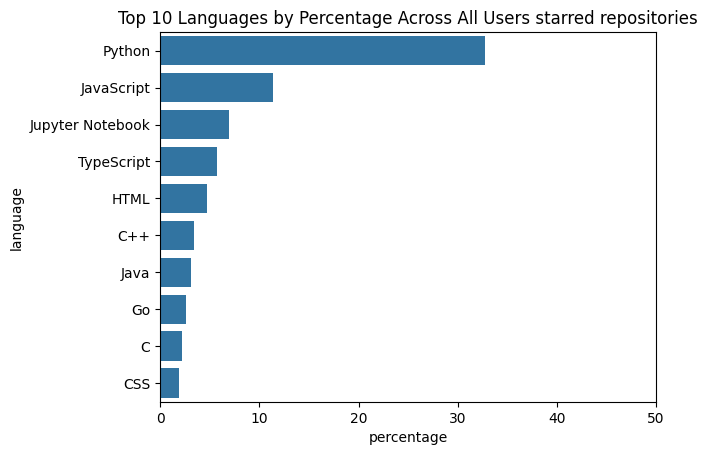

In [81]:
plot_top10_language_percentage(starred_data, title = 'Top 10 Languages by Percentage Across All Users starred repositories', xlim=50)

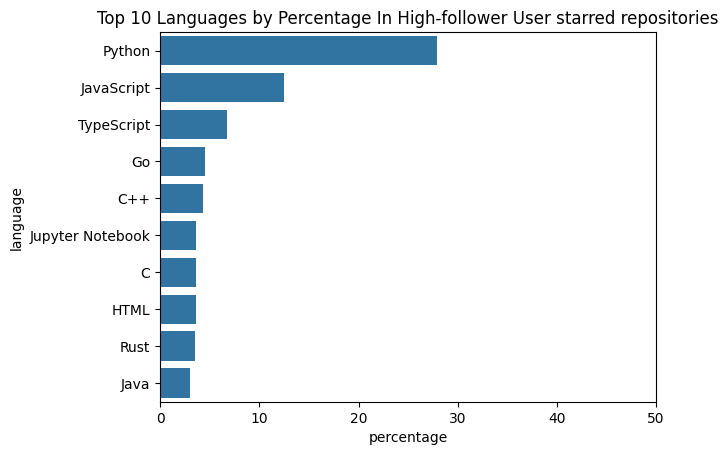

In [82]:
plot_top10_language_percentage(high_follower_starred_data, title = 'Top 10 Languages by Percentage In High-follower User starred repositories', xlim=50)

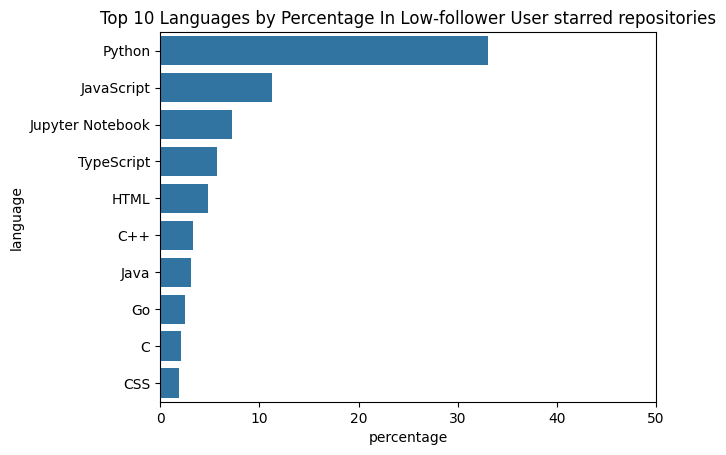

In [83]:
plot_top10_language_percentage(low_follower_starred_data, title = 'Top 10 Languages by Percentage In Low-follower User starred repositories', xlim=50)

It’s clear that there are differences in the programming languages starred by high-follower and low-follower users like `Python`, `Jupyter Notebook`, `HTML`, `Java`, `C++`, etc.

`JavaScript`, and `TypeScript` are consistently the top three most popular languages across all users, high-follower users, and low-follower users.

In [84]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], starred_data, on='user_alias')

In [85]:
merged_data = merged_data[['user_alias', 'followers', 'language']]

In [86]:
merged_data = merged_data.groupby(['user_alias', 'followers', 'language']).size().unstack(fill_value=0)

In [87]:
total = merged_data.sum(axis=1)
transformed_data = merged_data.div(total, axis=0)
transformed_data.reset_index(inplace=True)

In [88]:
transformed_data.head()

language,user_alias,followers,1C Enterprise,AGS Script,ANTLR,ASL,ASP,ASP.NET,ActionScript,Ada,...,YAML,YARA,Yacc,ZenScript,Zig,hoon,kvlang,reStructuredText,sed,wdl
0,usr10,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010309,0.0,0.0,0.0,0.0,0.0
1,usr1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,usr101,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,usr1010,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,usr1013,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [89]:
language_to_check = ('Python', 'Jupyter Notebook', 'HTML', 'Java', 'C++', 'C', 'C#', 'CSS', 'Go', 'Rust')

In [90]:
significant_result = []

for language in language_to_check:
    X = transformed_data[language]
    y = transformed_data['followers']
    results = regression_analysis(X, y)
    
    if results.pvalues[language] < 0.05:
        significant_result.append((language, results))

In [91]:
len(significant_result)

1

In [92]:
significant_result[0]

('Go',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1a27efe55a0>)

In [93]:
significant_result[0][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.859
Date:                Mon, 08 Apr 2024   Prob (F-statistic):            0.00886
Time:                        23:26:38   Log-Likelihood:                -26206.
No. Observations:                3627   AIC:                         5.242e+04
Df Residuals:                    3625   BIC:                         5.243e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8759      5.774      4.655      0.000      15.556      38.196
Go           151.1590     57.719      2.619      0.009      37.995     264.323
==============================================================================
Omnibus:                     9792.285   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        234462609.626
Skew:                          32.597   Prob(JB):                         0.00
Kurtosis:                    1246.864   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
significant_result[0][1].pvalues['Go']

0.008858275412048656

the p-value for `Go` is 0.00886, which is less than 0.05. Therefore, the assumption that the amount of a repository that user starred which used `Go` as a main language have an effects on users' follower count is statistically supported.

for each users' starred repository that used `Go` as a main language, their followers will increase by about 1.51.

In [95]:
user_aggregates = starred_data.groupby('user_alias')[['stargazers_count']].sum().reset_index()

In [96]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], user_aggregates, on='user_alias')

In [97]:
merged_data['user_type'] = ['high-follower user' if x > threshold else 'low-follower user' for x in merged_data['followers']]

In [98]:
merged_data.head()

,user_alias,followers,stargazers_count,user_type
0,usr5,0.0,257.0,low-follower user
1,usr6,1.0,76876.0,low-follower user
2,usr7,3.0,128402.0,low-follower user
3,usr10,126.0,2513974.0,high-follower user
4,usr11,7.0,836642.0,low-follower user


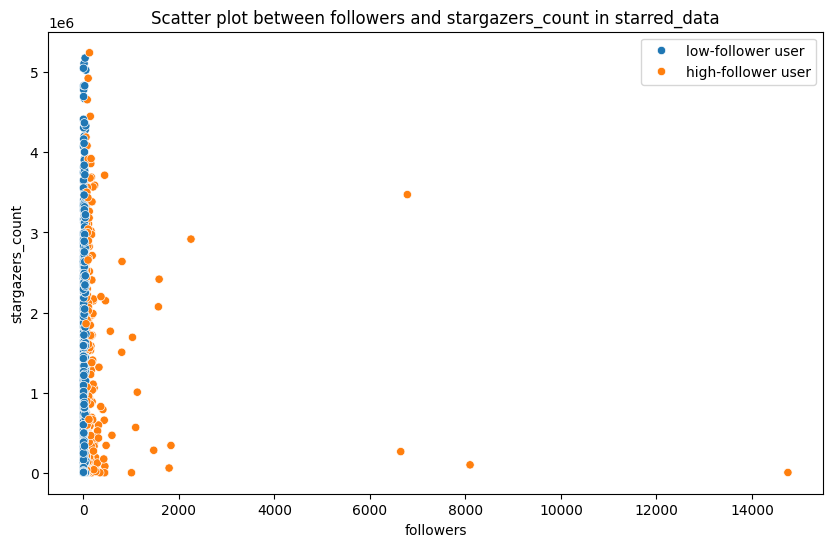

In [99]:
plot_scatter(df = merged_data, field_x = 'followers', field_y = 'stargazers_count', field_type = 'user_type', title = 'Scatter plot between followers and stargazers_count in starred_data')

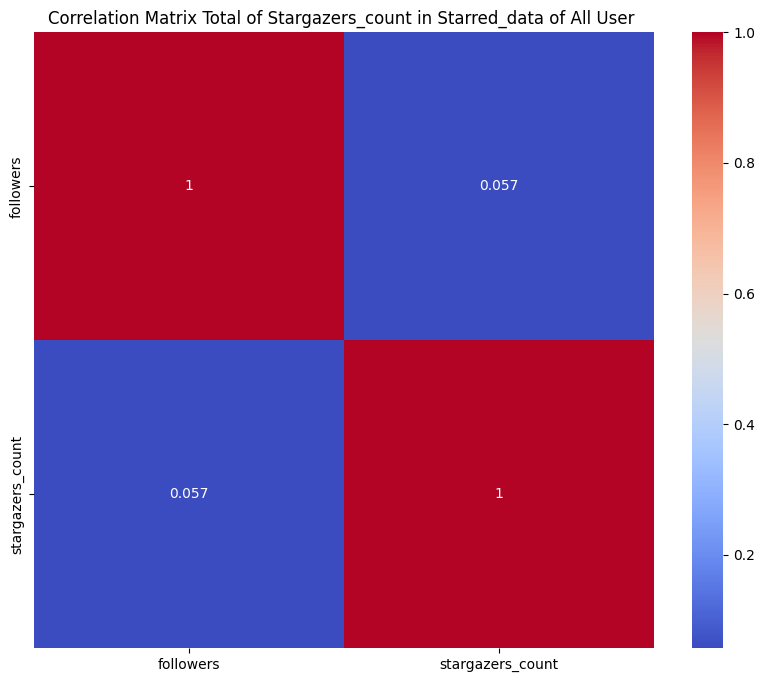

In [100]:
corr = plot_corr(select_numeric_column(merged_data), title='Correlation Matrix Total of Stargazers_count in Starred_data of All User ')

By analyzing the correlation matrix that includes the cumulative count of stargazers in starred data for all users, no significant correlation was found.

In [101]:
corr

,followers,stargazers_count
followers,1.000000,0.057026
stargazers_count,0.057026,1.000000
